<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FFFFFF; font-size:300%; text-align:left; padding:3.0px; background: #0A0F29; border-bottom: 8px solid #00FFFF; border-radius: 15px;">
    PS-S4.E11 | Explore Best Models<br>
</div>

<div style="text-align: center;">
  <img src="https://i.imgur.com/EhXAhl1.jpg" alt="Centered Image" style="max-width: 60%; height: auto;">
</div>

Photo de <a href="https://unsplash.com/fr/@dmey503?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Dan Meyers</a> sur <a href="https://unsplash.com/fr/photos/nabandonnez-pas-vous-netes-pas-seul-vous-comptez-sur-la-signalisation-sur-la-cloture-metallique-hluOJZjLVXc?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# Challenge overview

## Competition

- **Objective:** Participants analyze a synthetic dataset based on a mental health survey to identify factors linked to depression, predicting whether individuals are likely to experience depression.
- **Evaluation:** Submissions are scored by accuracy, with predictions required for each row in the test set as either 0 (no depression) or 1 (depression).

## Notebook aim

- In this notebook I compare several models in order to select the best 3.

In [1]:
ENV = 'Kaggle'
DEV = False  # Set to True to enable subsetting, False for full training data
SUBSET_SIZE = 1000  # Number of samples for the subset during development

In [2]:
if ENV == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
!python --version

Python 3.10.14


In [4]:
if ENV == 'Kaggle':
    print('configure Kaggle env')
    !pip install autogluon.tabular  > /dev/null 2>&1
    !pip install optuna-integration[sklearn] > /dev/null 2>&1
    !pip install langchain-core > /dev/null 2>&1
    !pip install langchain-openai  > /dev/null 2>&1
    !pip install sweetviz > /dev/null 2>&1
    !pip install numba==0.58.1 visions==0.7.5 pandas==1.5.3 ydata-profiling==4.7.0 > /dev/null 2>&1

if ENV == 'Colab':
    print('configure Colab env')
    !pip install -r /content/drive/MyDrive/Kaggle_analysis/PS4E11/requirements.txt > /dev/null 2>&1
    !pip install scikit-learn==1.3.0
    !pip install shap

configure Kaggle env


In [5]:
# Import libraries

# LLM Libraries
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# General Purpose Libraries
import json
import logging
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import warnings
from IPython.display import Markdown, display, IFrame
from scipy.stats import ttest_ind, stats

# Scikit-Learn Utilities
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, RobustScaler,
                                   PolynomialFeatures, KBinsDiscretizer)
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, RandomizedSearchCV)

# Scikit-Learn Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, VotingClassifier)

# External Libraries Classifiers
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, log_evaluation

# Metrics and Scoring
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, make_scorer, roc_auc_score, 
                             confusion_matrix, ConfusionMatrixDisplay)

# Feature Engineering
from featuretools import dfs, EntitySet

# Optuna for Hyperparameter Tuning
import optuna
from optuna.integration import OptunaSearchCV

# AutoML
from autogluon.tabular import TabularPredictor

# SHAP for Explainability
import shap

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
if ENV == 'Kaggle':
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    OPENAI_API_KEY = user_secrets.get_secret("openai_key")

if ENV == 'Sagemaker':
    with open('/home/ec2-user/SageMaker/API_keys/open_ai.txt', 'r') as file:
        OPENAI_API_KEY = file.read().strip()

if ENV == 'Colab':
    with open('/content/drive/MyDrive/Kaggle_analysis/API_keys/open_ai.txt', 'r') as file:
        OPENAI_API_KEY = file.read().strip()

In [7]:
# Define the LLM model using LangChain
model = ChatOpenAI(
    model='gpt-4o-2024-05-13',
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [8]:
# Function to classify columns into continuous and categorical
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Function to perform basic visualizations for continuous and categorical features
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)

    # Plotting continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

    # Plotting categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Count plot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Function to compare train and test datasets
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)

    # Compare continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # Compare categorical columns
    for col in categorical_cols:
        if col in test.columns:  # Ensure the column exists in the test dataset
            plt.figure(figsize=(10, 4))
            train_counts = train[col].value_counts(normalize=True)
            test_counts = test[col].value_counts(normalize=True)
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()

# Function to create key statistics for a dataset
def eda_summary(df):
    summary = {}

    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }

    # Column Data Types
    summary['data_types'] = df.dtypes.to_dict()

    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )

    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .to_dict(orient='index')
    )

    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )

    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns
    }

    # Correlations
    try:
        summary['correlations'] = df.corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."

    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

In [9]:
# Load the dataset

if ENV == 'Kaggle':
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
    sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

if ENV == 'Sagemaker':
    train_data = pd.read_csv('/home/ec2-user/SageMaker/data/PS4E11/train.csv')
    test_data = pd.read_csv('/home/ec2-user/SageMaker/data/PS4E11/test.csv')
    sample_submission = pd.read_csv('/home/ec2-user/SageMaker/data/PS4E11/sample_submission.csv')

if ENV == 'Colab':
    train_data = pd.read_csv('/content/drive/MyDrive/Kaggle_analysis/PS4E11/data/train.csv')
    test_data = pd.read_csv('/content/drive/MyDrive/Kaggle_analysis/PS4E11/data/test.csv')
    sample_submission = pd.read_csv('/content/drive/MyDrive/Kaggle_analysis/PS4E11/data/sample_submission.csv')

# Automated EDA

In [10]:
train_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [11]:
test_data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [12]:
sample_submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [13]:
# Generate the report with Sweetviz
target_variable = "Depression"
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat=target_variable)
report_path = 'Comparative_EDA_Report.html'
report.show_html(filepath=report_path, open_browser=False)

# Display the report inline in Kaggle
IFrame(src=report_path, width=1000, height=600)

                                             |          | [  0%]   00:00 -> (? left)

Report Comparative_EDA_Report.html was generated.


In [14]:
summary = eda_summary(train_data)
summary_json = json.dumps(summary, indent=4, default=str)

In [15]:
# Define the prompt template for LangChain
template = """Provide an analysis of the following EDA summary, The aim of this dataset and EDA is to understand how several variables influence depression.
Ultimately the aim is to build a classification model to predict depression:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json)

# Print the result
display(Markdown(result))

Based on the provided EDA summary, here are some key insights and observations:

### General Overview
- **Dataset Size**: The dataset contains 140,700 rows and 20 columns.
- **Missing Values**: There are 430,876 missing values, which account for approximately 15.31% of the total data. This is a significant amount and will need to be addressed during preprocessing.

### Data Types
- The dataset contains a mix of numerical (`int64`, `float64`) and categorical (`object`) variables.
- The target variable, `Depression`, is of type `int64`, which is suitable for classification tasks.

### Missing Values
- **High Missingness**: Several columns have a high percentage of missing values:
  - `Academic Pressure` (80.17%)
  - `CGPA` (80.17%)
  - `Study Satisfaction` (80.17%)
  - `Profession` (26.03%)
  - `Work Pressure` (19.84%)
  - `Job Satisfaction` (19.83%)
- **Low Missingness**: Some columns have very few missing values:
  - `Dietary Habits` (0.0028%)
  - `Degree` (0.0014%)
  - `Financial Stress` (0.0028%)

### Categorical Summary
- **High Cardinality**: Columns like `Name` (422 unique values), `City` (98 unique values), `Profession` (64 unique values), `Sleep Duration` (36 unique values), `Dietary Habits` (23 unique values), and `Degree` (115 unique values) have a high number of unique values.
- **Binary Categories**: Columns like `Gender`, `Working Professional or Student`, `Have you ever had suicidal thoughts?`, and `Family History of Mental Illness` have only 2 unique values, making them binary categorical variables.

### Skewness and Kurtosis
- Most numerical variables have skewness and kurtosis values close to zero, indicating that they are approximately normally distributed.
- The `Depression` variable has a high skewness (1.65) and kurtosis (0.73), suggesting a right-skewed distribution with a heavy tail.

### Correlations
- **Strong Correlations**:
  - `Depression` is positively correlated with `Academic Pressure` (0.475), `Work Pressure` (0.217), `Work/Study Hours` (0.192), and `Financial Stress` (0.227).
  - `Depression` is negatively correlated with `Age` (-0.565), `Study Satisfaction` (-0.168), and `Job Satisfaction` (-0.169).
- **Weak or No Correlations**:
  - Variables like `id`, `CGPA`, and `Financial Stress` have very weak correlations with most other variables.

### Outliers
- **Depression**: The `Depression` variable has a significant number of outliers (18.17% of the data). This could indicate that there are extreme values in the dataset that may need to be addressed.
- **Other Variables**: No outliers were detected in other numerical variables.

### Key Insights and Observations
1. **High Missingness**: The high percentage of missing values in several key variables (e.g., `Academic Pressure`, `CGPA`, `Study Satisfaction`) will need to be addressed. Imputation or removal of these variables might be necessary.
2. **High Cardinality**: Variables with high cardinality (e.g., `Name`, `City`, `Profession`) may need to be encoded appropriately to avoid issues during model training.
3. **Correlations**: The strong correlations between `Depression` and variables like `Academic Pressure`, `Work Pressure`, `Work/Study Hours`, and `Financial Stress` suggest that these variables are important predictors of depression.
4. **Outliers**: The presence of outliers in the `Depression` variable indicates that there may be extreme cases that could affect the model's performance. These outliers may need to be handled appropriately.
5. **Binary Variables**: The binary categorical variables (e.g., `Gender`, `Working Professional or Student`, `Have you ever had suicidal thoughts?`, `Family History of Mental Illness`) can be easily encoded and may provide valuable information for the classification model.

### Next Steps
1. **Data Cleaning**: Address missing values through imputation or removal of variables with excessive missingness.
2. **Feature Engineering**: Encode categorical variables, especially those with high cardinality, using techniques like one-hot encoding or target encoding.
3. **Outlier Treatment**: Handle outliers in the `Depression` variable to ensure they do not adversely affect the model.
4. **Model Building**: Use the insights from the EDA to select relevant features and build a classification model to predict depression. Consider using techniques like logistic regression, decision trees, or ensemble methods.

By addressing these key points, you can improve the quality of the dataset and build a more accurate and robust classification model for predicting depression.

# Explore best models

In [16]:
# Split the data into training and testing datasets
X = train_data.drop(['Depression', 'id'], axis=1)
y = train_data['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Subset the training data if DEV is True
if DEV:
    subset_indices = np.random.choice(X_train.index, size=min(SUBSET_SIZE, len(X_train)), replace=False)
    X_train = X_train.loc[subset_indices]
    y_train = y_train.loc[subset_indices]

print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

Shape of training data: (112560, 18)
Shape of testing data: (28140, 18)


In [17]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Creating a preprocessing pipeline
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ])

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'SGDClassifier': SGDClassifier(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

# Stratified K-Fold for balanced sampling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training models and evaluating performance using ROC AUC score
scores = {}
for name, model in models.items():
    # For AUC scoring, SVC needs `probability=True`
    if name == 'SVC':
        model.probability = True
        
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    scores[name] = cv_scores
    print(f"{name}: {cv_scores.mean()} ± {cv_scores.std()}")

RandomForest: 0.9688570882048786 ± 0.0008531386620602593
LogisticRegression: 0.9742404849850258 ± 0.0009270509608500665
SVC: 0.9663740044134164 ± 0.0015355692136330324
SGDClassifier: 0.9732295468088827 ± 0.0009700796326941749
RidgeClassifier: 0.9679602637829344 ± 0.0014579721958332713
XGBoost: 0.9737245851054246 ± 0.0007657810851769208
[LightGBM] [Info] Number of positive: 16331, number of negative: 73717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 90048, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181359 -> initscore=-1.507168
[LightGBM] [Info] Start training from score -1.507168
[LightGBM] [Info] Number of positive: 16331, number of negative: 73717
[LightGBM] [Info] Auto-choosing r

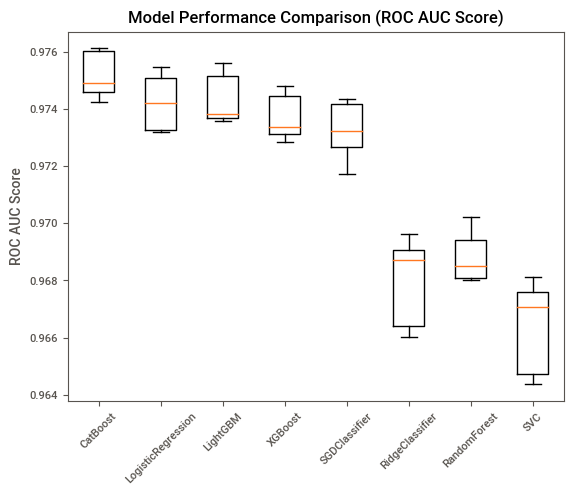

In [18]:
# Plotting model performances for ROC AUC
sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: -np.median(item[1]))}

plt.boxplot(sorted_scores.values(), labels=sorted_scores.keys())
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (ROC AUC Score)')
plt.ylabel('ROC AUC Score')
plt.show()